In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

In [ ]:
!unzip /content/drive/MyDrive/Datasets/waste-classification.zip

In [3]:
from glob import glob
O_1 = glob("/content/DATASET/TRAIN/O/*.jpg")
R_1 = glob('/content/DATASET/TRAIN/R/*.jpg')

In [4]:
O_1 = O_1[:800]
R_1 = R_1[:800]

In [5]:
!mkdir "/content/train"

!mkdir "/content/train/O"
files = ' '.join(O_1)
!mv -t "/content/train/O" $files

!mkdir "/content/train/R"
files = ' '.join(R_1)
!mv -t "/content/train/R" $files

In [6]:
training_folder_name = '/content/train'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['O', 'R']


In [7]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.7.1+cu101


In [8]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [9]:
training_folder_name = '/content/train'

# New location for the resized images
train_folder = '/content/train_resized'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder O
processing folder R
Done.


In [10]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.75 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader




#####################################################################################################




# Recall that we have resized the images and saved them into
train_folder = '/content/train_resized'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read /content/train_resized


In [17]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=2, bias=True)
)


In [18]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        #print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [19]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [20]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0007)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 30
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set: Average loss: 0.548402
Validation set: Average loss: 0.443193, Accuracy: 321/400 (80%)

Epoch: 2
Training set: Average loss: 0.474244
Validation set: Average loss: 0.499821, Accuracy: 306/400 (76%)

Epoch: 3
Training set: Average loss: 0.447295
Validation set: Average loss: 0.435964, Accuracy: 322/400 (80%)

Epoch: 4
Training set: Average loss: 0.444349
Validation set: Average loss: 0.435090, Accuracy: 329/400 (82%)

Epoch: 5
Training set: Average loss: 0.409170
Validation set: Average loss: 0.450750, Accuracy: 321/400 (80%)

Epoch: 6
Training set: Average loss: 0.412647
Validation set: Average loss: 0.416226, Accuracy: 331/400 (83%)

Epoch: 7
Training set: Average loss: 0.386003
Validation set: Average loss: 0.412653, Accuracy: 327/400 (82%)

Epoch: 8
Training set: Average loss: 0.374743
Validation set: Average loss: 0.411788, Accuracy: 326/400 (82%)

Epoch: 9
Training set: Average loss: 0.359791
Validation set: Average loss: 0.442244, Accuracy: 

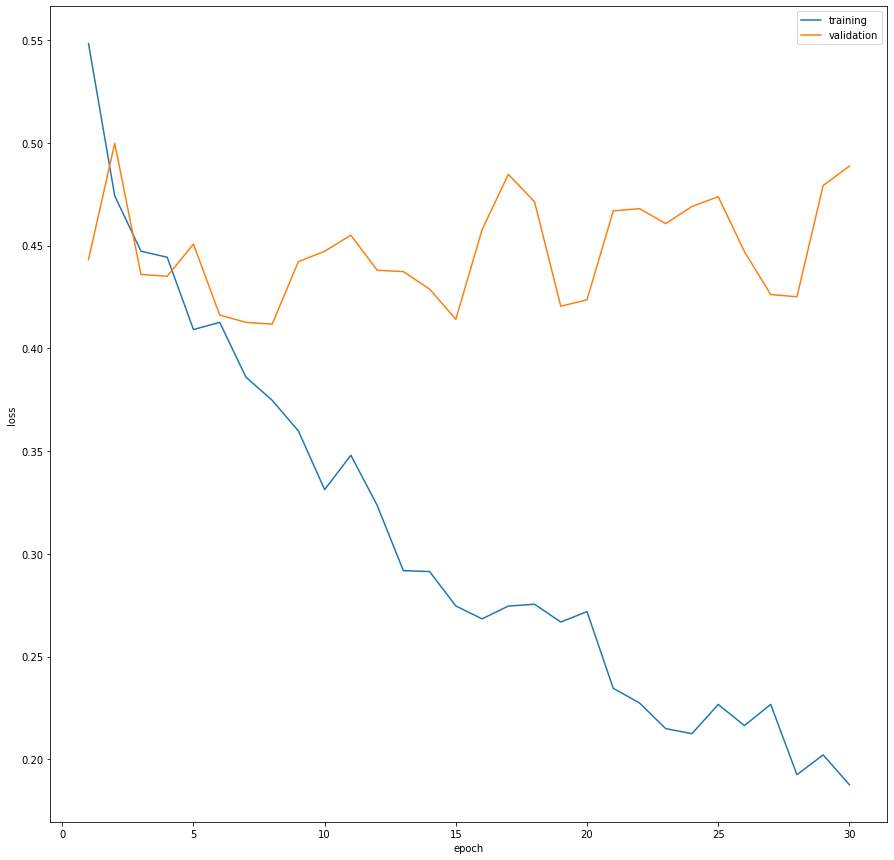

In [21]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


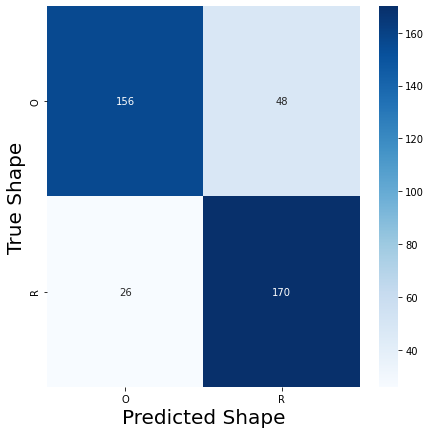

In [22]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [23]:
from sklearn import metrics
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('ROC-AUC:\n', metrics.roc_auc_score(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [24]:
metrics.classification_report(truelabels,predictions)

'              precision    recall  f1-score   support\n\n           0       0.86      0.76      0.81       204\n           1       0.78      0.87      0.82       196\n\n    accuracy                           0.81       400\n   macro avg       0.82      0.82      0.81       400\nweighted avg       0.82      0.81      0.81       400\n'

In [25]:
performance_matrix(truelabels,predictions)

Confusion Matrix:
 [[156  48]
 [ 26 170]]
ROC-AUC:
 0.8160264105642256
Precision: 81.84796854521625 Recall: 81.60264105642257, Accuracy: 81.5: ,f1_score: 81.47730970438786
